## Analysis

In [46]:
from embeddings import GloveEmbedding, FastTextEmbedding
from models.dan import DAN 
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings(action = 'ignore')
 
from tqdm import tqdm
import pandas as pd
import torch
from dataset.dataloader import ClassificationDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

cpu_device = torch.device("cpu")

Device: cuda
LABELS - [1, 2, 3, 4, 5]
LABELS DICT- {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
LABELS - [1, 2, 3, 4, 5]
LABELS DICT- {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}


EPOCH: 5 LOSS: 1.114231561054534 Val Accuracy: 0.8001665278934221 Val Loss: 1.1069644689559937:   3%| | 3/100 [00:00<00:03, 27

N Classes 5


EPOCH: 100 LOSS: 1.1108410821286618 Val Accuracy: 0.8001665278934221 Val Loss: 1.1046675443649292: 100%|█| 100/100 [00:04<00:0


BEST VAL ACCURACY - 0.8001665278934221
BEST VAL F1-SCORE - 0.17779833487511562
[[  0   0   0   0  59]
 [  0   0   0   0  19]
 [  0   0   0   0  32]
 [  0   0   0   0 130]
 [  0   0   0   0 961]]


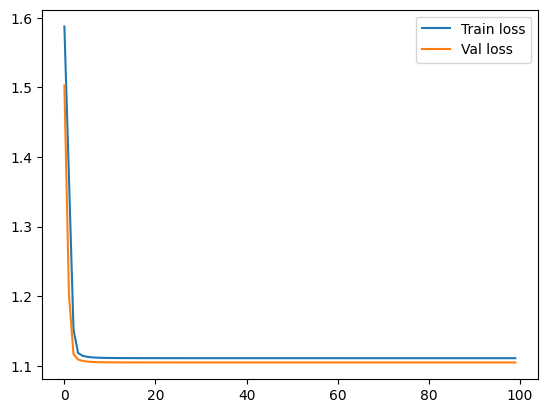

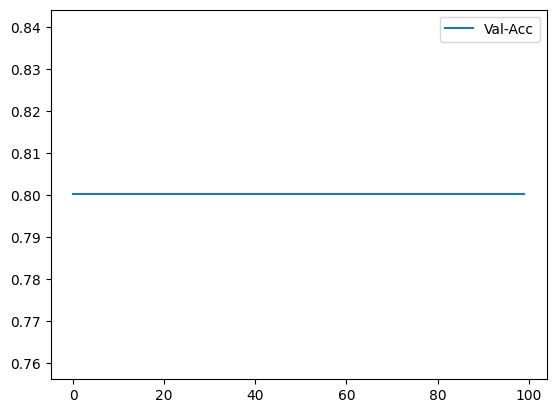

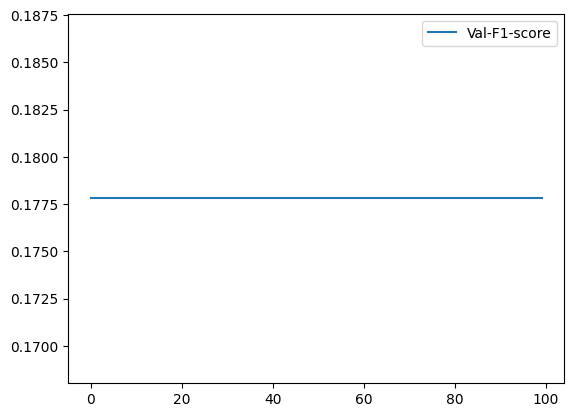

In [53]:
# import argparse
# parser = argparse.ArgumentParser()
# parser
# parser.parse_args()

fasttext = FastTextEmbedding()
glove = GloveEmbedding('wikipedia_gigaword', d_emb=300, show_progress=True)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

emb_model = fasttext

BATCH_SIZE = 128
DATASET_NO = 2
EPOCHS = 100
classes_dict = {0:3, 1:2, 2:5} # DATASET_NO: N_Classes
N_CLASSES = classes_dict[DATASET_NO]
train_dataset = ClassificationDataset(emb_model, split="train", dataset_no=DATASET_NO)
test_dataset = ClassificationDataset(emb_model, split="valid", dataset_no=DATASET_NO)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print("N Classes", N_CLASSES)
nn_model = DAN(n_classes=N_CLASSES).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optimizer = torch.optim.Adam(nn_model.parameters())


running_loss = 0.
last_loss = 0.

metrics = {
"train_losses" : [],
"val_losses" : [],
"val_accs" : [],
"val_f1_score" : []
}

train_losses = []
val_losses = []
val_accs = []

tq = tqdm(range(EPOCHS))
for epoch, _ in enumerate(tq):
    for X_train, y_train in train_dataloader:
        # Every data instance is an input + label pair
        inputs, labels = X_train, y_train
        # import pdb; pdb.set_trace()
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = nn_model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        
    test_logits = nn_model(test_dataset.X)
    y_pred = torch.argmax(test_logits, axis=-1)
    metrics["train_losses"].append(BATCH_SIZE*running_loss/len(train_dataset))
    metrics["val_losses"].append(loss_fn(test_logits, test_dataset.y))
    val_accuracy = nn_model.get_accuracy(test_dataset.y, y_pred)
    metrics["val_accs"].append(val_accuracy)

    f1_score = nn_model.get_f1_score(test_dataset.y, y_pred)
    metrics["val_f1_score"].append(f1_score)

    tq.set_description_str(f"EPOCH: {epoch+1} LOSS: {BATCH_SIZE*running_loss/len(train_dataset)} Val Accuracy: {val_accuracy} Val Loss: {loss_fn(test_logits, test_dataset.y)}")

    running_loss = 0

plt.figure()
plt.plot(torch.tensor(metrics["train_losses"]).to("cpu"), label="Train loss")
plt.plot(torch.tensor(metrics["val_losses"]).to("cpu"), label="Val loss")
plt.legend()
# plt.savefig(f"plots/D{DATASET_NO}/losses_fasttext_{EPOCHS}_{BATCH_SIZE}_D{DATASET_NO}.pdf")

plt.figure()
plt.plot(torch.tensor(metrics["val_accs"]).to("cpu"), label="Val-Acc")
plt.legend()
# plt.savefig(f"plots/D{DATASET_NO}/val_accs_fasttext_{EPOCHS}_{BATCH_SIZE}_D{DATASET_NO}.pdf")

plt.figure()
plt.plot(torch.tensor(metrics["val_f1_score"]).to("cpu"), label="Val-F1-score")
plt.legend()
# plt.savefig(f"plots/D{DATASET_NO}/f1_score_fasttext_{EPOCHS}_{BATCH_SIZE}_D{DATASET_NO}.pdf")

print(f'BEST VAL ACCURACY - {max(metrics["val_accs"])}')
print(f'BEST VAL F1-SCORE - {max(metrics["val_f1_score"])}')

cf = sklearn.metrics.confusion_matrix(test_dataset.y.to(cpu_device), y_pred.to(cpu_device))
print(cf)

In [59]:
torch.max(test_dataset.X), torch.min(test_dataset.X)

(tensor(0.4599, device='cuda:0'), tensor(-0.8423, device='cuda:0'))

In [54]:
torch.

tensor([4], device='cuda:0')

In [14]:
y = np.random.random_integers(0,1, size=2000)
y_pred = np.random.random_integers(0,1, size=2000)
print(sklearn.metrics.accuracy_score(y, y_pred))
print((y == y_pred).mean())

0.503
0.503


In [34]:
n = 20
y_true_toy = test_dataset.y[:n]
logits_toy = nn_model(test_dataset.X[:n])
y_pred_toy = (torch.argmax(logits_toy,axis=-1)).to(torch.device("cpu"))
print(sklearn.metrics.accuracy_score(y_true_toy.to(torch.device("cpu")), y_pred_toy))
print(nn_model.get_accuracy(logits_toy, y_true_toy))

0.85
tensor(0.8500)


In [31]:
(torch.argmax(logits_toy,axis=-1) == y_true_toy).to(torch.float)

tensor([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 1.], device='cuda:0')

In [25]:
y_pred_toy

tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       dtype=torch.int32)

In [32]:
(y_pred_toy == y_true_toy.to(torch.device("cpu"))).to(torch.float)

tensor([1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
        1., 0.])

In [21]:
from embeddings import GloveEmbedding, FastTextEmbedding

In [22]:
import numpy as np

from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings(action = 'ignore')
 
import gensim
from gensim.models import Word2Vec, FastText
import pandas as pd
from gensim.utils import simple_preprocess
from gensim.models import KeyedVectors, FastText
from gensim import models

In [2]:
# word2vec_path = "/home/karm/karm_8T/embeddings/wordtovec/GoogleNews-vectors-negative300.bin.gz"
# w2v_model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# model_path = "/home/karm/karm_8T/embeddings/fasttext/wiki-news-300d-1M.vec"
# ft_model = models.KeyedVectors.load_word2vec_format(model_path)
# model = ft_model

model_path = "/home/karm/karm_8T/embeddings/fasttext/crawl-300d-2M-subword.bin"
ft_model = FastText.load_fasttext_format(model_path)
model = ft_model.wv

/home/karm/miniconda3/envs/torch37/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  if sys.path[0] == "":


In [3]:
model.similarity("shoes","university")

0.25400066

In [4]:
model["alokwlcd"] #OoV handling

array([-0.00707852, -0.02047246,  0.05881367,  0.02716566,  0.00643048,
       -0.0723402 ,  0.01739277,  0.0193181 , -0.03043089, -0.03515377,
        0.00977802, -0.00776978,  0.01736763, -0.00835331,  0.0017135 ,
       -0.02628151,  0.02115601,  0.01426279,  0.02096461, -0.00731205,
       -0.00760224, -0.02462225, -0.00832718,  0.00256635, -0.04368203,
        0.0271911 , -0.10531273,  0.0301073 ,  0.01034641, -0.0252064 ,
       -0.02112975, -0.00563607, -0.02726468,  0.01614374,  0.01965702,
       -0.02949228,  0.02880771,  0.00392867,  0.00592084,  0.01363917,
       -0.03160523, -0.05507934, -0.00380419, -0.00375819,  0.02180936,
        0.0718902 , -0.00805254, -0.01753271, -0.01452723, -0.00027653,
       -0.02285302,  0.00174166,  0.01675   ,  0.00954768, -0.04940724,
        0.00881833,  0.00740869, -0.04042297,  0.04220759, -0.02088748,
        0.0133517 , -0.02707481, -0.05293711, -0.01553095, -0.03796826,
        0.00598069, -0.02043743, -0.02528773,  0.00756693, -0.03

In [25]:
file_path = "dataset/ClassificationDataset-train1.xlsx"

In [26]:
df = pd.read_excel(file_path)
df

,Negative Review,Positive Review
0,I am so angry that i made this post available ...,Only the park outside of the hotel was beauti...
1,No Negative,No real complaints the hotel was great great ...
2,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...
3,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...
4,You When I booked with your company on line yo...,Amazing location and building Romantic setting
...,...,...
6327,Roadworks made it difficult to access hotel b...,Helpful staff excellent breakfast
6328,Restaurant was little cramped,Staff friendly Lovely clean room Good facilities
6329,more comfortable seats in bar,very family friendly staff
6330,No Negative,The rooms was excellent Value for money


In [ ]:
torch.unique()

In [18]:
list(df["neutral"].unique()).index("positive")

0

In [99]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/karm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [100]:
simple_preprocess("hi my name is karm, your name is trankesh")

['hi', 'my', 'name', 'is', 'karm', 'your', 'name', 'is', 'trankesh']

In [101]:
sent_tokenize("hi my name is karm your name is trankesh")

['hi my name is karm your name is trankesh']

In [102]:
word_tokenize("hi my name is karm")

['hi', 'my', 'name', 'is', 'karm']

In [103]:
data = df["text"].apply(lambda x: word_tokenize(x)).to_list()
# data = df["text"].apply(lambda x: simple_preprocess(" ".join(word_tokenize(x)))).to_list()

In [104]:
data[5], df.iloc[5,1]

(['Citigroup',
  ',',
  'Inc',
  '(',
  'NYSE',
  ':',
  'C',
  ')',
  'has',
  'announced',
  'that',
  'its',
  'Global',
  'Transaction',
  'Services',
  '(',
  'GTS',
  ')',
  'business',
  'has',
  'been',
  'awarded',
  'a',
  'new',
  'mandate',
  'by',
  'Finland-based',
  'Pohjola',
  'Bank',
  'Group',
  '.'],
 'Citigroup , Inc ( NYSE : C ) has announced that its Global Transaction Services ( GTS ) business has been awarded a new mandate by Finland-based Pohjola Bank Group .')

In [108]:
for i,sent in enumerate(data):
    for word in sent:
        model.get_vector(word)
    print(i)

In [110]:
model.get_vector("phone").shape

(300,)

## FNN

In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

In [132]:
DATASET_NO = 0
labels_dict = {'positive':1, 'neutral':0, 'negative':2}
get_file_path = lambda split: f"dataset_splits/ClassificationDataset-{split}{DATASET_NO}.xlsx"

In [133]:
def get_x_y(split="train"):
    file_path  = get_file_path(split)
    df = pd.read_excel(file_path, names=["label","text"])
    
    data = df["text"].apply(lambda x: word_tokenize(x)).to_list()
    X_train = torch.tensor(np.array([np.array([model.get_vector(word) for word in sent]).sum(axis=0) for i,sent in enumerate(data)]))
    y_train = torch.tensor(df["label"].apply(lambda x: labels_dict[x]))
    print(X_train.shape, y_train.shape)
    return X_train, y_train

In [134]:
X_train, y_train = get_x_y("train")
X_val, y_val = get_x_y("valid")

torch.Size([2797, 300]) torch.Size([2797])
torch.Size([1202, 300]) torch.Size([1202])


In [135]:
class Fnn(nn.Module):
    def __init__(self, d=300, n_classes=3):
        super(Fnn, self).__init__()
        self.layer_1 = nn.Linear(d,128)
        self.layer_2 = nn.Linear(128,n_classes)
        
    def forward(self, x):
        # x.shape = (b, 300)
        x = self.layer_1(x)
        x = F.relu(x)
        
        x = self.layer_2(x)
        x = F.log_softmax(x)
        
        return x # (b,3)
    
class DAN2(nn.Module):
    def __init__(self, d=300, n_classes=3):
        super(DAN2, self).__init__()
        self.layer_1 = nn.Linear(d,150)
        self.layer_2 = nn.Linear(150, 75)
        self.layer_3 = nn.Linear(75, n_classes)
        
        
    def forward(self, x):
        # x.shape = (b, 300)
        x = self.layer_1(x)
        x = F.relu(x)
        
        x = self.layer_2(x)
        x = F.relu(x)
        
        x = self.layer_3(x)
        x = F.log_softmax(x)
        
        return x # (b,3)

In [136]:
torch.cuda.is_available()

True

In [137]:
device = torch.device("cuda")
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

In [138]:
nn_model = Fnn().to(device)
# nn_model = DAN2().to(device)

In [139]:
# test
loss_fn = torch.nn.CrossEntropyLoss()

dummy_outputs = torch.exp(nn_model(X_train[:4,:]))
# Represents the correct class among the 10 being tested
dummy_labels = y_train[:4]

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.3020, 0.4106, 0.2874],
        [0.2910, 0.4090, 0.3001],
        [0.2352, 0.4486, 0.3162],
        [0.2517, 0.4271, 0.3212]], device='cuda:0', grad_fn=<ExpBackward>)
tensor([1, 0, 0, 1], device='cuda:0')
Total loss for this batch: 1.093355417251587


In [140]:
optimizer = torch.optim.SGD(nn_model.parameters(),lr=0.01,momentum=0.9)

In [141]:
def get_accuracy(logits, y_true):
    return (torch.argmax(logits,axis=-1) == y_true).to(torch.float).mean()

In [142]:
running_loss = 0.
last_loss = 0.
batch_size = 64

train_losses = []
val_losses = []
val_accs = []
EPOCHS = 100

tq = tqdm(range(EPOCHS))
for epoch, _ in enumerate(tq):
    
    for i in range(0,X_train.shape[0],batch_size):
        # Every data instance is an input + label pair
        inputs, labels = X_train[i:i+batch_size, :], y_train[i:i+batch_size]

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = nn_model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        
    val_accuracy = get_accuracy(nn_model(X_val), y_val)    
    tq.set_description_str(f"EPOCH: {epoch+1} LOSS: {batch_size*running_loss/X_train.shape[0]} Val Accuracy: {val_accuracy} Val Loss: {loss_fn(nn_model(X_val), y_val)}")
    
    if epoch%1 == 0:
        train_losses.append(batch_size*running_loss/X_train.shape[0])
        val_losses.append(loss_fn(nn_model(X_val), y_val))
        val_accs.append(val_accuracy)
    
    running_loss = 0

EPOCH: 100 LOSS: 0.25935899115989663 Val Accuracy: 0.7495840191841125 Val Loss: 0.7120609283447266: 100%|█| 100/100 [00:03<


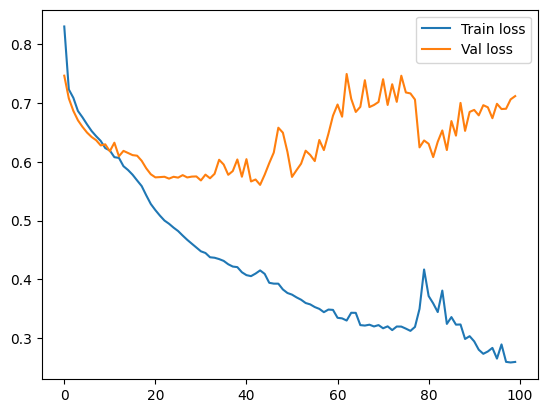

In [143]:
plt.plot(torch.tensor(train_losses).to("cpu"), label="Train loss")
plt.plot(torch.tensor(val_losses).to("cpu"), label="Val loss")
# plt.plot(torch.tensor(val_accs).to("cpu"))
plt.legend();

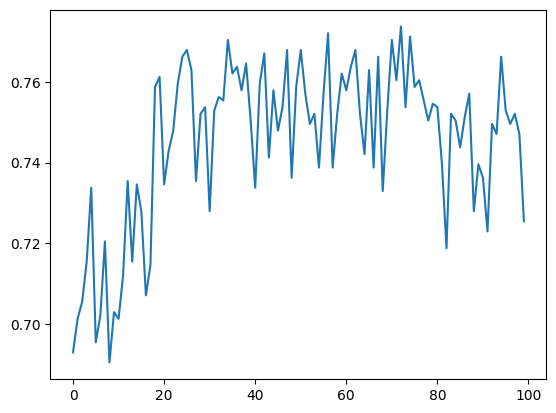

In [130]:
plt.plot(torch.tensor(val_accs).to("cpu"));

In [13]:
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
	def __init__(self):
		self.imgs_path = "Dog_Cat_Dataset/"
		file_list = glob.glob(self.imgs_path + "*")
		print(file_list)
		self.data = []
		for class_path in file_list:
			class_name = class_path.split("/")[-1]
			for img_path in glob.glob(class_path + "/*.jpeg"):
				self.data.append([img_path, class_name])
		print(self.data)
		self.class_map = {"dogs" : 0, "cats": 1}
		self.img_dim = (416, 416)
	
	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		img_path, class_name = self.data[idx]
		img = cv2.imread(img_path)
		img = cv2.resize(img, self.img_dim)
		class_id = self.class_map[class_name]
		img_tensor = torch.from_numpy(img)
		img_tensor = img_tensor.permute(2, 0, 1)
		class_id = torch.tensor([class_id])
		return img_tensor, class_id

if __name__ == "__main__":
	dataset = CustomDataset()		
	data_loader = DataLoader(dataset, batch_size=4, shuffle=True)
	for imgs, labels in data_loader:
		print("Batch of images has shape: ",imgs.shape)
		print("Batch of labels has shape: ", labels.shape)

[]
[]


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [19]:
g.em

TypeError: __init__() missing 1 required positional argument: 'emb_model'